In [2]:
# Calculate the dataset mean and standard deviation of pixel values across all pixels across dataset.
# Reason: Better feature detection specific to dataset using pretrained model.
from PIL import Image
from glob import glob
import numpy as np
from tqdm import tqdm
import os

train_data_paths = [("exo","exo_PNG"),("typ", "typ_PNG")]

data_path = os.path.join(os.getcwd(), "Data", "unl", "unl_PNG","*.png")
paths = glob(data_path)

means, stds = [], []

for (path_root, sub_dirs) in train_data_paths:
    full_directory = glob(os.path.join(os.getcwd(), 'Augmented_Data' , path_root , sub_dirs, '*.png'))
    # print(f'Currently in {full_directory}')
    for files in tqdm(full_directory):
        image = Image.open(files).convert('L')
        image = np.array(image) / 255.0          # scale to [0, 1]
        means.append(image.mean())
        stds.append(image.std())


# for path in tqdm(paths):
#     img = Image.open(path).convert("L")  # grayscale
#     img = np.array(img) / 255.0          # scale to [0, 1]
#     means.append(img.mean())
#     stds.append(img.std())

dataset_mean = np.mean(means)
dataset_std = np.mean(stds)

print(f"Dataset mean: {dataset_mean:.4f}")
print(f"Dataset std: {dataset_std:.4f}")


100%|██████████| 11430/11430 [01:10<00:00, 161.54it/s]

Dataset mean: 0.0664
Dataset std: 0.1239


In [3]:
import numpy as np
from PIL import Image as PILImage
import torchvision.transforms as T
import matplotlib.pyplot as plt

# Pre-process input data.
def normalize_image(image_path):
    # print(image_path)
    # 1. Open image and convert to greyscale.
    image = PILImage.open(image_path).convert('L')
    image_array = np.array(image, dtype=np.float32)

    # 2. Apply log scaling (to normalize pixel brightness)
    image_array_scaled = np.log1p(image_array)

    # 3. Normalize image by 99th percentile (Clip outliers so they have less sway)
    p_low, p_high = np.percentile(image_array_scaled, (1, 99))
    image_array_percentile = np.clip((image_array_scaled - p_low) / (p_high - p_low), 0, 1)

    # Convert to tensor
    transform = T.Compose([
        T.ToTensor(),
        T.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat channel 3x
        T.Resize((224, 224)),
        T.RandomRotation(360),
        T.RandomHorizontalFlip(),
        T.Normalize(mean=[dataset_mean]*3, std=[dataset_std]*3)
    ])

    return transform(Image.fromarray((image_array_percentile * 255).astype(np.uint8)))



In [4]:
output_dir = "Data/preprocessed"
os.makedirs(output_dir+'/exo/exo_PNG', exist_ok=True)
os.makedirs(output_dir+'/typ/typ_PNG', exist_ok=True)
# paths = sorted(glob(data_path))
# print(f"Found {len(paths)} images to preprocess.")

for (path_root, sub_dirs) in train_data_paths:
    full_directory = glob(os.path.join(os.getcwd(), 'Augmented_Data' , path_root , sub_dirs, '*.png'))
    # print(f'Currently in {path_root}. found {len(full_directory)} images to preprocess.')

    for file in tqdm(full_directory):
        normalized_image = normalize_image(file)
        filename = os.path.basename(file)
        save_path = os.path.join(output_dir, path_root ,sub_dirs , filename)

        # Save as uint8 grayscale PNG
        img_np = normalized_image.permute(1,2,0).numpy()
        Image.fromarray((img_np * 255).astype(np.uint8)).save(save_path)

# for path in tqdm(paths, desc="Preprocessing"):
#     print(f"Preprocessing {path}")
#     img = normalize_image(path)
#     filename = os.path.basename(path)
#     save_path = os.path.join(output_dir, filename)
#
#     # Save as uint8 grayscale PNG
#     Image.fromarray((img * 255).astype(np.uint8)).save(save_path)

print("✅ Done preprocessing!")
#
# # --- 4️⃣ Visual sanity check ---
#
# sample_paths = np.random.choice(paths, 3, replace=False)
# fig, axs = plt.subplots(2, 3, figsize=(10, 6))
#
# for i, p in enumerate(sample_paths):
#     original = np.array(Image.open(p).convert("RGB"))
#     processed = normalize_image(p)
#
#     axs[0, i].imshow(original)
#     axs[0, i].set_title("Original")
#     axs[0, i].axis("off")
#
#     axs[1, i].imshow(processed, cmap="gray")
#     axs[1, i].set_title("Processed")
#     axs[1, i].axis("off")
#
# plt.tight_layout()
# plt.show()

100%|██████████| 11430/11430 [01:09<00:00, 164.94it/s]

✅ Done preprocessing!


In [5]:
import torch
import torch.nn.functional as F
from torchvision import transforms as T
from PIL import Image
import glob
from tqdm import tqdm
import numpy as np

import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")  # This will fail if no CUDA

# If CUDA available is False, you need to reinstall PyTorch

print('Initialize feature extraction...........')
# Load pretrained DINOv2 model (ViT-Large backbone)
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
model.eval().cuda()  # Move to GPU

transform = T.Compose([
    T.Resize((224, 224)),
    T.Grayscale(num_output_channels=3),
    T.ToTensor(),
    T.Normalize(mean=[dataset_mean] * 3, std=[dataset_std] * 3)
])

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
Initialize feature extraction...........


Using cache found in C:\Users\Kopan/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\Kopan/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\Kopan/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\Kopan/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, datasets
from transformers import AutoModel, AutoImageProcessor
from tqdm import tqdm

# ==============================
# 1. Dataset + transforms
# ==============================
training_data_path = os.path.join(os.getcwd(), "Augmented_Data", "unl", "unl_PNG", "*.png")

# Example dataset (replace with your own)
train_dataset = datasets.ImageFolder("Data/preprocessed/", transform=transform)
val_dataset = datasets.ImageFolder("Data/unl", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

num_classes = len(train_dataset.classes)

# ==============================
# 2️⃣ Load DINOv2 backbone
# ==============================

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
backbone = AutoModel.from_pretrained("facebook/dinov2-base")

# Freeze everything (we’ll only train adapters + classifier)
for param in backbone.parameters():
    param.requires_grad = False


# ==============================
# 3️⃣ Define Adapter Module
# ==============================

class Adapter(nn.Module):
    def __init__(self, hidden_dim, adapter_dim=64):
        super().__init__()
        self.down = nn.Linear(hidden_dim, adapter_dim)
        self.act = nn.ReLU()
        self.up = nn.Linear(adapter_dim, hidden_dim)

    def forward(self, x):
        return x + self.up(self.act(self.down(x)))  # Residual connection


# ==============================
# 4️⃣ Add adapters + classifier
# ==============================

class DinoWithAdapters(nn.Module):
    def __init__(self, backbone, num_classes, adapter_dim=64):
        super().__init__()
        self.backbone = backbone
        hidden_dim = backbone.config.hidden_size
        self.adapter = Adapter(hidden_dim, adapter_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values=pixel_values)
        last_hidden_state = outputs.last_hidden_state.mean(dim=1)  # [batch, hidden_dim]
        adapted = self.adapter(last_hidden_state)
        logits = self.classifier(adapted)
        return logits


model = DinoWithAdapters(backbone, num_classes).to(device)

# Only train adapters + classifier
for name, param in model.named_parameters():
    if "adapter" in name or "classifier" in name:
        param.requires_grad = True

# ==============================
# 5️⃣ Training setup
# ==============================

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
epochs = 15

# ==============================
# 6️⃣ Training loop
# ==============================

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch + 1}: Train Loss = {avg_loss:.4f}")

    print(f"Epoch {epoch + 1}: Validation Phase:")
    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            correct += (preds.argmax(1) == labels).sum().item()
            total += labels.size(0)
    print(f"Val Accuracy: {100 * correct / total:.2f}%")

# ==============================
# 7️⃣ Save tuned model
# ==============================
torch.save(model.state_dict(), "dinov2_adapter_tuned.pth")
print("✅ Adapter-tuned DINOv2 saved.")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Epoch 1/15: 100%|██████████| 735/735 [02:56<00:00,  4.16it/s]


Epoch 1: Train Loss = 0.1127
Epoch 1: Validation Phase:
Val Accuracy: 0.41%


Epoch 2/15: 100%|██████████| 735/735 [01:54<00:00,  6.40it/s]


Epoch 2: Train Loss = 0.0923
Epoch 2: Validation Phase:
Val Accuracy: 11.03%


Epoch 3/15: 100%|██████████| 735/735 [01:54<00:00,  6.42it/s]


Epoch 3: Train Loss = 0.0830
Epoch 3: Validation Phase:
Val Accuracy: 5.09%


Epoch 4/15: 100%|██████████| 735/735 [01:54<00:00,  6.42it/s]


Epoch 4: Train Loss = 0.0747
Epoch 4: Validation Phase:
Val Accuracy: 10.19%


Epoch 5/15: 100%|██████████| 735/735 [01:53<00:00,  6.48it/s]


Epoch 5: Train Loss = 0.0669
Epoch 5: Validation Phase:
Val Accuracy: 8.76%


Epoch 6/15: 100%|██████████| 735/735 [01:53<00:00,  6.46it/s]


Epoch 6: Train Loss = 0.0615
Epoch 6: Validation Phase:
Val Accuracy: 9.40%


Epoch 7/15: 100%|██████████| 735/735 [01:53<00:00,  6.49it/s]


Epoch 7: Train Loss = 0.0550
Epoch 7: Validation Phase:
Val Accuracy: 9.09%


Epoch 8/15: 100%|██████████| 735/735 [01:56<00:00,  6.33it/s]


Epoch 8: Train Loss = 0.0503
Epoch 8: Validation Phase:
Val Accuracy: 13.27%


Epoch 9/15: 100%|██████████| 735/735 [01:52<00:00,  6.54it/s]


Epoch 9: Train Loss = 0.0476
Epoch 9: Validation Phase:
Val Accuracy: 19.10%


Epoch 10/15: 100%|██████████| 735/735 [01:52<00:00,  6.53it/s]


Epoch 10: Train Loss = 0.0417
Epoch 10: Validation Phase:
Val Accuracy: 14.74%


Epoch 11/15: 100%|██████████| 735/735 [01:54<00:00,  6.40it/s]


Epoch 11: Train Loss = 0.0397
Epoch 11: Validation Phase:
Val Accuracy: 13.39%


Epoch 12/15: 100%|██████████| 735/735 [01:52<00:00,  6.53it/s]


Epoch 12: Train Loss = 0.0347
Epoch 12: Validation Phase:
Val Accuracy: 14.17%


Epoch 13/15: 100%|██████████| 735/735 [01:52<00:00,  6.52it/s]


Epoch 13: Train Loss = 0.0308
Epoch 13: Validation Phase:
Val Accuracy: 20.74%


Epoch 14/15: 100%|██████████| 735/735 [01:52<00:00,  6.54it/s]


Epoch 14: Train Loss = 0.0273
Epoch 14: Validation Phase:
Val Accuracy: 16.80%


Epoch 15/15: 100%|██████████| 735/735 [01:51<00:00,  6.56it/s]


Epoch 15: Train Loss = 0.0255
Epoch 15: Validation Phase:
Val Accuracy: 13.62%
✅ Adapter-tuned DINOv2 saved.


In [8]:
model.eval()
torch.set_grad_enabled(False)


transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

def extract_embedding(model, img_path, transform, device="cuda"):
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        # Get DINOv2 hidden state
        outputs = model.backbone(pixel_values=x)
        hidden = outputs.last_hidden_state.mean(dim=1)  # [batch, hidden_dim]

        # Apply adapter
        adapted = model.adapter(hidden)

        # THIS is your final embedding
        embedding = adapted.squeeze().cpu().numpy()

    return embedding


In [17]:
import numpy as np
from glob import glob
from tqdm import tqdm

print(train_data_paths)

embeddings = []
paths_out = []

for (path_root, sub_dirs) in train_data_paths:
    full_directory = glob(os.path.join(os.getcwd(), 'Data/preprocessed' , path_root , sub_dirs, '*.png'))

    print(f"Extracting embeddings from Data/preprocessed/{path_root}")

    for file in tqdm(full_directory,  desc="Extracting embeddings"):
        emb = extract_embedding(model, file, transform)
        embeddings.append(emb)
        paths_out.append(file)

embeddings = np.vstack(embeddings)
np.save("embeddings_dinov2_adapter.npy", embeddings)

print("✅ Done. Embedding shape:", embeddings.shape)

# embed_images_path = os.path.join(os.getcwd(), "Augmented_Data", "unl", "unl_PNG", "*.png")
# print(embed_images_path)
#
# image_paths = sorted(glob('Data/preprocessed/'))
#
# print(image_paths)

#
# for p in tqdm(image_paths, desc="Extracting embeddings"):
#     emb = extract_embedding(model, p, transform)
#     embeddings.append(emb)
#     paths_out.append(p)
#
# embeddings = np.vstack(embeddings)
# np.save("embeddings_dinov2_adapter.npy", embeddings)
#
# print("✅ Done. Embedding shape:", embeddings.shape)


[('exo', 'exo_PNG'), ('typ', 'typ_PNG')]
Extracting embeddings from Data/preprocessed/exo


Extracting embeddings: 100%|██████████| 330/330 [00:04<00:00, 69.38it/s]


Extracting embeddings from Data/preprocessed/typ


Extracting embeddings: 100%|██████████| 11430/11430 [02:40<00:00, 71.04it/s]


✅ Done. Embedding shape: (11760, 768)


In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import numpy as np

embeddings = np.load("embeddings_dinov2_adapter.npy")
# print(embeddings.shape)

# Normalize embeddings.
embeddings_norm = normalize(embeddings, norm='l2')
print(embeddings_norm.shape)


# Apply PCA.
pca = PCA(n_components=50, random_state=42)
emb_pca = pca.fit_transform(embeddings_norm)

print("PCA output shape:", emb_pca.shape)
print("Variance retained:", pca.explained_variance_ratio_.sum())


(11760, 768)
PCA output shape: (11760, 50)
Variance retained: 0.8579443


In [21]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40,     # tune based on desired granularity
    min_samples=10,          # controls noise vs cluster strictness
    metric='euclidean',      # PCA output is suited for euclidean
    cluster_selection_method='eom',
    prediction_data=True
)

labels = clusterer.fit_predict(emb_pca)


C:\Users\Kopan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Kopan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [22]:
# Explain the clustering
import numpy as np

unique, counts = np.unique(labels, return_counts=True)
cluster_dist = dict(zip(unique, counts))

print("Cluster distribution:")
for k, v in cluster_dist.items():
    print(f"  Cluster {k}: {v} samples")

print("Noise points (-1):", np.sum(labels == -1))
print("Number of clusters:", len(unique) - (1 if -1 in unique else 0))


Cluster distribution:
  Cluster -1: 788 samples
  Cluster 0: 42 samples
  Cluster 1: 10930 samples
Noise points (-1): 788
Number of clusters: 2


C:\Users\Kopan\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


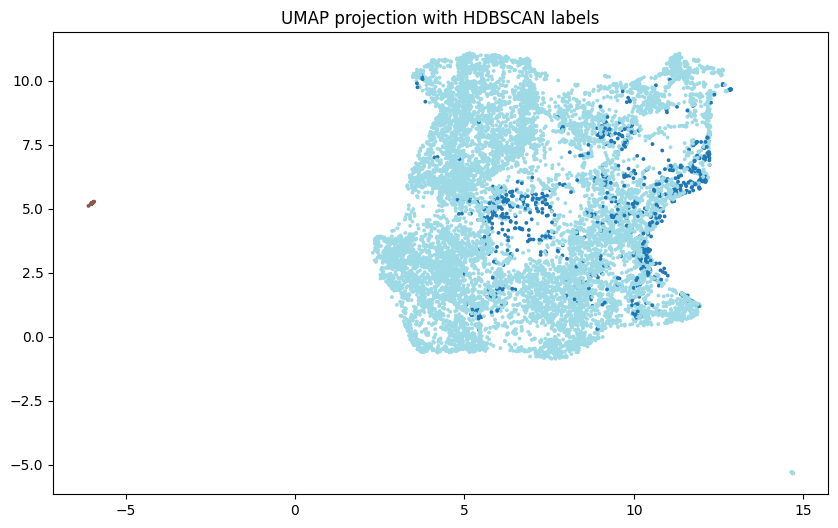

In [23]:
#Visualise with UMAP
import umap
import matplotlib.pyplot as plt

um = umap.UMAP(n_components=2, random_state=42)
emb_umap = um.fit_transform(emb_pca)

plt.figure(figsize=(10, 6))
plt.scatter(emb_umap[:,0], emb_umap[:,1], c=labels, s=3, cmap="tab20")
plt.title("UMAP projection with HDBSCAN labels")
plt.show()


In [ ]:
# import torch
# import torch.nn as nn
# from transformers import AutoImageProcessor, AutoModel
# from PIL import Image
# import numpy as np
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# from typing import List, Optional
# import os
#
# class DINOv2Classifier:
#     def __init__(self, model_name: str = "facebook/dinov2-base"):
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         self.processor = AutoImageProcessor.from_pretrained(model_name)
#         self.model = AutoModel.from_pretrained(model_name).to(self.device)
#         self.model.eval()
#
#     def extract_embeddings(self, image_paths: List[str]) -> np.ndarray:
#         """Extract embeddings from images"""
#         embeddings = []
#
#         for image_path in image_paths:
#             try:
#                 # Load and preprocess image
#                 image = Image.open(image_path).convert('RGB')
#                 inputs = self.processor(image, return_tensors="pt").to(self.device)
#
#                 # Extract features
#                 with torch.no_grad():
#                     outputs = self.model(**inputs)
#                     # Use CLS token or average patch tokens
#                     embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
#                     embeddings.append(embedding[0])
#
#             except Exception as e:
#                 print(f"Error processing {image_path}: {e}")
#                 continue
#
#         return np.array(embeddings)
#
#     def extract_embeddings_batch(self, images: List[Image.Image]) -> np.ndarray:
#         """Extract embeddings from PIL images in batch"""
#         embeddings = []
#
#         # Process in batches to optimize memory
#         batch_size = 32
#         for i in range(0, len(images), batch_size):
#             batch_images = images[i:i+batch_size]
#
#             # Preprocess batch
#             inputs = self.processor(
#                 batch_images,
#                 return_tensors="pt",
#                 padding=True
#             ).to(self.device)
#
#             # Extract features
#             with torch.no_grad():
#                 outputs = self.model(**inputs)
#                 batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
#                 embeddings.extend(batch_embeddings)
#
#         return np.array(embeddings)
#
# # Usage example
# classifier = DINOv2Classifier()
#
# # Extract embeddings from a folder of images
# def process_image_folder(folder_path: str):
#     image_paths = []
#     for file_name in os.listdir(folder_path):
#         if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
#             image_paths.append(os.path.join(folder_path, file_name))
#
#     embeddings = classifier.extract_embeddings(image_paths)
#     return embeddings, image_paths
# data_path = os.path.join(os.getcwd(), "Data", "unl", "unl_PNG","*.png")
# embeddings, image_paths = process_image_folder(data_path)